8.1 Проведите извлечение признаков из wells_info_with_prod.csv (хоть один из столбцов с датой и категориальным признаком должен остаться). Целевой переменной будет Prod1Year

In [92]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import numpy as np

In [93]:
df_main = pd.read_csv('data/wells_info_with_prod.csv')
df_main.head()

,API,PermitDate,SpudDate,CompletionDate,FirstProductionDate,operatorNameIHS,formation,BasinName,StateName,CountyName,LatWGS84,LonWGS84,BottomHoleLatitude,BottomHoleLongitude,LATERAL_LENGTH_BLEND,PROP_PER_FOOT,WATER_PER_FOOT,Prod1Year,ProdAll
0,5005072170100,2014-05-06,2014-05-06,2014-12-02,2014-11-01 00:00:00.000,BURLINGTON RESOURCES O&G CO LP,NIOBRARA,DENVER BASIN,COLORADO,ARAPAHOE,39.684606,-104.642128,39.68445,-104.60557,9005.0,994.6866,591.8004,126898,201325
1,5123377130000,2013-07-21,2013-10-06,2014-02-26,2014-02-01 00:00:00.000,SRC ENERGY INCORPORATED,NIOBRARA,DENVER BASIN,COLORADO,WELD,40.509320,-104.780980,40.49692,-104.77859,4195.0,991.5857,628.6321,22616,34625
2,5123379280000,2013-09-08,2013-09-25,2014-09-07,2013-11-01 00:00:00.000,BONANZA CREEK ENERGY OPERATING CO LLC,NIOBRARA,DENVER BASIN,COLORADO,WELD,40.335390,-104.363000,40.34780,-104.36863,4273.0,1000.2760,564.4841,47523,69009
3,5123379400000,2013-09-11,2014-12-05,2015-03-31,2015-03-01 00:00:00.000,NOBLE ENERGY INCORPORATED,NIOBRARA,DENVER BASIN,COLORADO,WELD,40.152220,-104.530780,40.17445,-104.52932,7078.0,973.4437,824.0020,59474,81048
4,5123385820100,2014-01-07,2014-01-13,2014-04-23,2014-04-01 00:00:00.000,GREAT WESTERN OPERATING COMPANY LLC,NIOBRARA,DENVER BASIN,COLORADO,WELD,40.508303,-104.868180,40.49558,-104.86757,3211.0,783.5919,603.1414,14427,18050


In [94]:
df_main = df_main[['CompletionDate', 'StateName', 'Prod1Year']]
df_main.head()

,CompletionDate,StateName,Prod1Year
0,2014-12-02,COLORADO,126898
1,2014-02-26,COLORADO,22616
2,2014-09-07,COLORADO,47523
3,2015-03-31,COLORADO,59474
4,2014-04-23,COLORADO,14427


1. Разделите данные Титаника (train.csv) на тренировочную, валидационную и тестовую часть. С помощью валидационной части подберите гиперпараметры для моделей Random Forest, XGBoost, Logistic Regression и KNN. Получите точность этих моделей на тестовой части.

In [95]:
df_main = pd.read_csv('data/titanic/train.csv')
df_main.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [96]:
def prepare_num(df):
    df_num = df.drop(['Sex', 'Embarked', 'Pclass'], axis=1)
    df_sex = pd.get_dummies(df['Sex'])
    df_emb = pd.get_dummies(df['Embarked'], prefix='Emb')
    df_pcl = pd.get_dummies(df['Pclass'], prefix='Pclass')

    df_num = pd.concat((df_num, df_sex, df_emb, df_pcl), axis=1)
    return df_num

In [97]:
def split_data(X_scaled, y):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
    return X_train, X_val, X_test, y_train, y_val, y_test

def scale_data(X):
    scaler = MinMaxScaler()
    return scaler.fit_transform(X)

In [98]:
y = df_main['Survived']
X = df_main.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
X_prepared = prepare_num(X)
X_prepared = X_prepared.fillna(X_prepared.median())
X_scaled = scale_data(X_prepared)
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X_scaled, y)
X_prepared

,Age,SibSp,Parch,Fare,female,male,Emb_C,Emb_Q,Emb_S,Pclass_1,Pclass_2,Pclass_3
0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1
1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0
2,26.0,0,0,7.9250,1,0,0,0,1,0,0,1
3,35.0,1,0,53.1000,1,0,0,0,1,1,0,0
4,35.0,0,0,8.0500,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,0,0,13.0000,0,1,0,0,1,0,1,0
887,19.0,0,0,30.0000,1,0,0,0,1,1,0,0
888,28.0,1,2,23.4500,1,0,0,0,1,0,0,1
889,26.0,0,0,30.0000,0,1,1,0,0,1,0,0


RandomForest

In [99]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [100]:
def random_forest(X_train, X_val, y_train, y_val):
    clf = RandomForestClassifier()
    parameters = {'n_estimators': range (10, 30, 10),
                  'max_depth': range (1,13, 2),
                  'min_samples_leaf': range (1,8),
                  'min_samples_split': range (2,10,2),
                  'criterion': ['gini', 'entropy', 'log_loss']}
    grid = GridSearchCV(clf, parameters, cv=5)
    grid.fit(X_train, y_train)
    max_depth = grid.best_params_.get("max_depth")
    min_samples_leaf = grid.best_params_.get("min_samples_leaf")
    min_samples_split = grid.best_params_.get("min_samples_split")
    n_estimators = grid.best_params_.get("n_estimators")
    criterion = grid.best_params_.get("criterion")
    model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
    model.fit(X_train, y_train)
    predict = model.predict(X_val)
    acc = accuracy_score(y_val, predict)
    print(f"Лучшие параметры:\n{grid.best_params_}")
    print("Лучшая accuracy: {:.2%}".format(acc))
    return model

In [101]:
def get_accuracy(model, X_test, y_test):
    predict = model.predict(X_test)
    return accuracy_score(y_test, predict)

In [102]:
model = random_forest(X_train, X_val, y_train, y_val)
get_accuracy(model, X_test, y_test)

Лучшие параметры:
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Лучшая accuracy: 81.82%


0.7877094972067039

2. С помощью RandomForest выберите 2, 4, 8 самых важных признаков и проверьте точность моделей только на этих признаках.

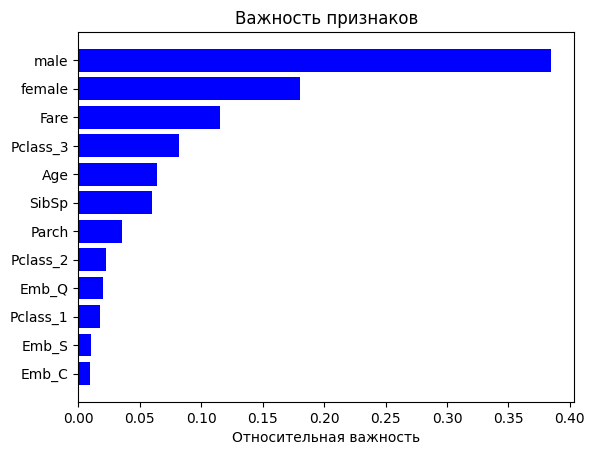

In [103]:
importances = model.feature_importances_
features = X_prepared.columns

# Добавление сортировки по важности
indices = np.argsort(importances)

plt.title('Важность признаков')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Относительная важность')
plt.show()

In [104]:
def test_n_features(model, X_prepared, y, n):
    X = X_prepared[features[indices][-n:]]
    X = scale_data(X)
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)
    model.fit(X_train, y_train)
    return get_accuracy(model, X_test, y_test)

In [105]:
test_n_features(model, X_prepared, y, 2)

0.776536312849162

In [106]:
test_n_features(model, X_prepared, y, 4)

0.8100558659217877

In [107]:
test_n_features(model, X_prepared, y, 8)

0.8100558659217877

3. Используя координаты скважин из файла wells_info.csv разделите их на кластера с помощью любых 4 методов и отобразите разделение. Параметры подбираются самостоятельно.

4. Приведите отобранные в 6.1 задании признаки из файла wells_info_with_prod.csv в двумерное пространство. Выделите цветом добычу с этой скважины.

Лабораторная работа 9.1 Титаник ML
1. Загрузить файл, разделить его на train и test. Для test взять 10% случайно выбранных строк таблицы.
2. Обучить модели: Decision Tree, XGBoost, Logistic Regression из библиотек sklearn и xgboost. Обучить модели предсказывать столбец label по остальным столбцам таблицы.
3. Наладить замер Accuracy - доли верно угаданных ответов.
4. Точности всех моделей не должны быть ниже 85%
5. С помощью Decision Tree выбрать 2 самых важных признака и проверить точность модели, обученной только на них.

In [108]:
df_main = pd.read_csv('data/titanic_prepared.csv')
df_main.head()

,Unnamed: 0,sex,row_number,liters_drunk,drink,check_number,label,age_child,age_adult,age_old,morning,day,evening
0,0,0,90.0,1.0,1,8092,1,False,False,True,False,False,True
1,1,0,81.0,4.0,1,4252,1,False,True,False,False,True,False
2,2,1,14.0,3.0,0,6913,1,False,False,True,False,False,True
3,3,1,0.0,1.0,0,8479,1,False,False,True,False,True,False
4,4,1,84.0,1.0,0,6279,0,False,False,True,True,False,False


In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)